<a href="https://colab.research.google.com/github/rahul078/ML-and-DL/blob/main/alzheihmer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/alzheimer/archive

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score, precision_score, accuracy_score, classification_report
from tensorflow import keras, one_hot
from keras import applications
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224,224]
BATCH_SIZE = 64
NUM_CLASSES = 4
DROUPOUT_RATE = 0.3
DIRECTORY_TRAIN = "./Alzheimer_s Dataset/train"
DIRECTORY_TEST = "./Alzheimer_s Dataset/test"

In [ ]:
train = image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

validation = image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


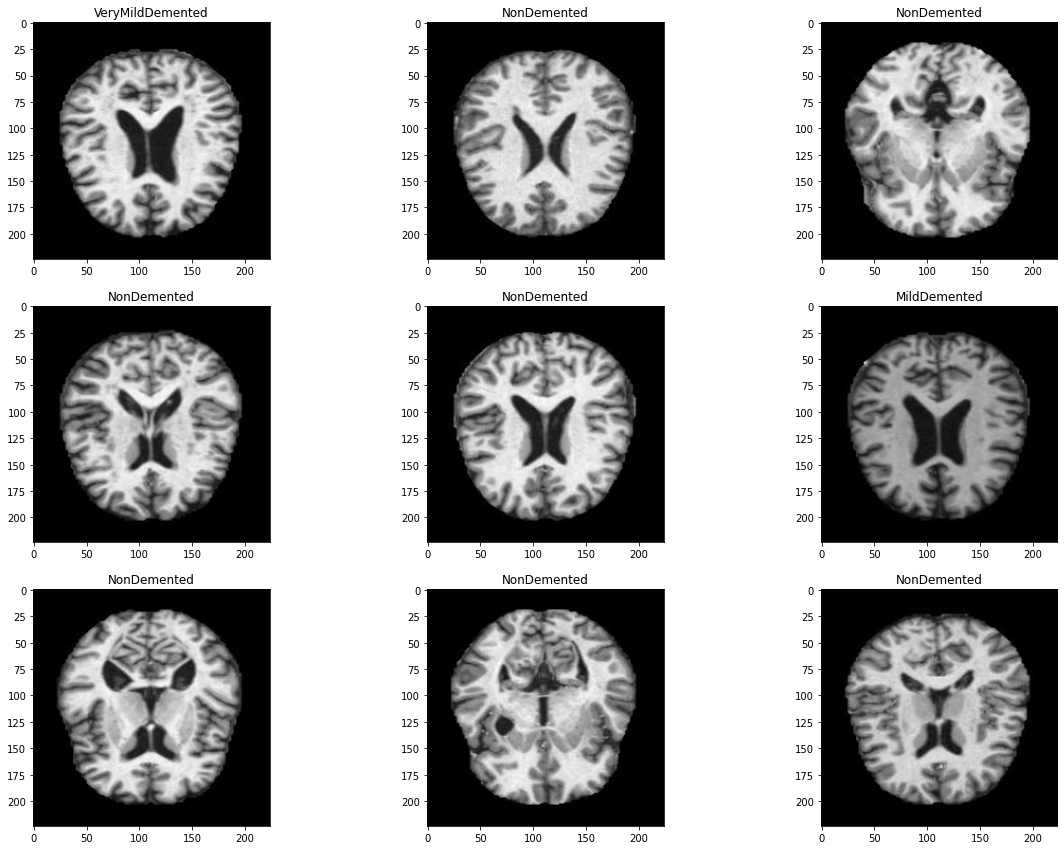

In [ ]:
batch = train.take(1)

plt.figure(figsize=(20,20))
for images in batch:
    for i in range(9):
        plt.subplot(4, 3, i + 1)
        image = images[0][i]
        label = images[1][i]
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(train.class_names[label])

In [ ]:
selected_classes = train.class_names
print(selected_classes)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
label_occurency = {0: 0, 1: 0, 2: 0, 3: 0}
for batch in train:
    label_occurency[0] += (batch[1].numpy() == 0).sum()
    label_occurency[1] += (batch[1].numpy() == 1).sum()
    label_occurency[2] += (batch[1].numpy() == 2).sum()
    label_occurency[3] += (batch[1].numpy() == 3).sum()
#     print(batch[1].numpy())
print(label_occurency)

{0: 578, 1: 39, 2: 2053, 3: 1427}


In [ ]:
def one_hot_label(image, label):
    label = one_hot(label, NUM_CLASSES)
    return image, label

In [ ]:
train = train.map(one_hot_label)
validation = validation.map(one_hot_label)

In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),  
    keras.metrics.AUC(name='auc')
]


In [ ]:
from keras.layers.core import Dropout

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = True

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(len(selected_classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 111, 111, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 mixed0 (Concatenate)           (None, 25, 25, 256)  0           ['activation_381[0][0]',         
                                                                  'activation_383[0][0]',         
                                                                  'activation_386[0][0]',         
                                                                  'activation_387[0][0]']         
                                                                                                  
 conv2d_391 (Conv2D)            (None, 25, 25, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 batch_normalization_391 (Batch  (None, 25, 25, 64)  192         ['conv2d_391[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [ ]:
epochs=3
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/3
65/65 [==============================] - 2046s 31s/step - loss: 0.7766 - accuracy: 0.8418 - precision: 0.7433 - recall: 0.5611 - auc: 0.8930 - val_loss: 2.6510 - val_accuracy: 0.7505 - val_precision: 0.5010 - val_recall: 0.5010 - val_auc: 0.7699
Epoch 2/3
65/65 [==============================] - 2018s 31s/step - loss: 0.1823 - accuracy: 0.9689 - precision: 0.9498 - recall: 0.9246 - auc: 0.9953 - val_loss: 1.3400 - val_accuracy: 0.8081 - val_precision: 0.6178 - val_recall: 0.6094 - val_auc: 0.8666
Epoch 3/3
65/65 [==============================] - 2033s 31s/step - loss: 0.0364 - accuracy: 0.9957 - precision: 0.9917 - recall: 0.9910 - auc: 0.9998 - val_loss: 0.4161 - val_accuracy: 0.9255 - val_precision: 0.8563 - val_recall: 0.8438 - val_auc: 0.9734


In [ ]:
def plot_metric(metric, history):
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history[metric])
    ax.plot(history.history['val_' + metric])
    ax.set_title(f'Model {metric}')
    ax.legend(['train', "validation"])
    ax.set_xlabel("epochs")
    ax.set_ylabel(metric)

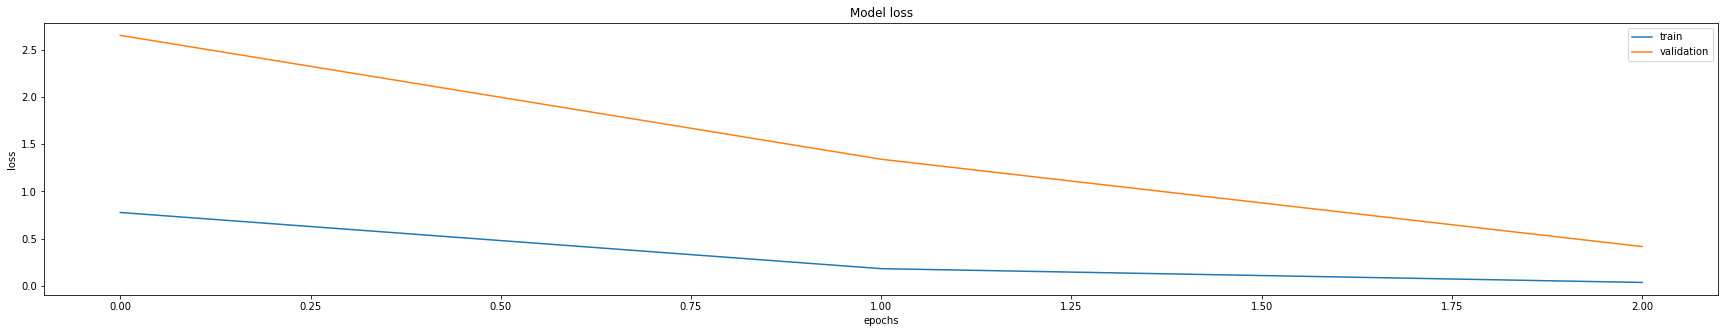

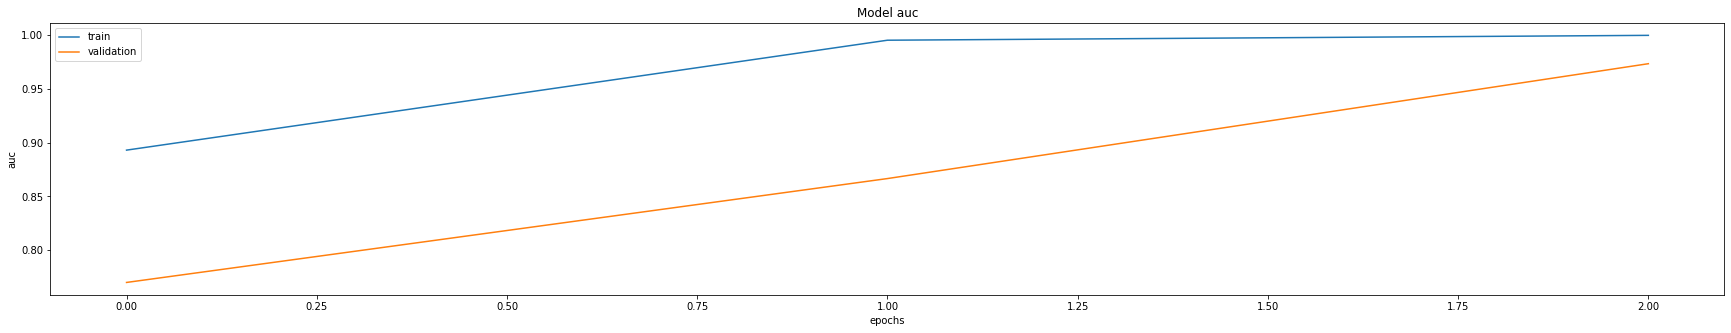

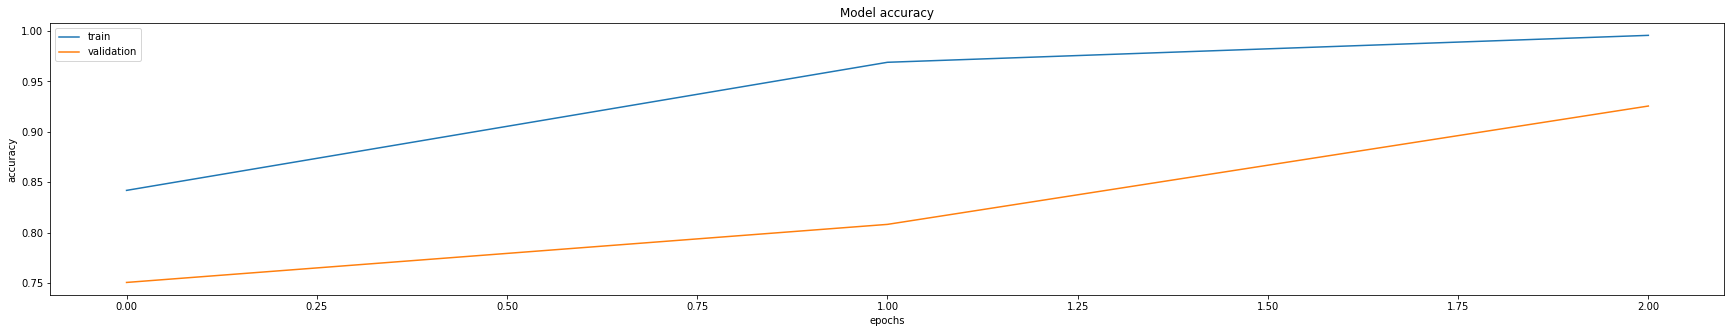

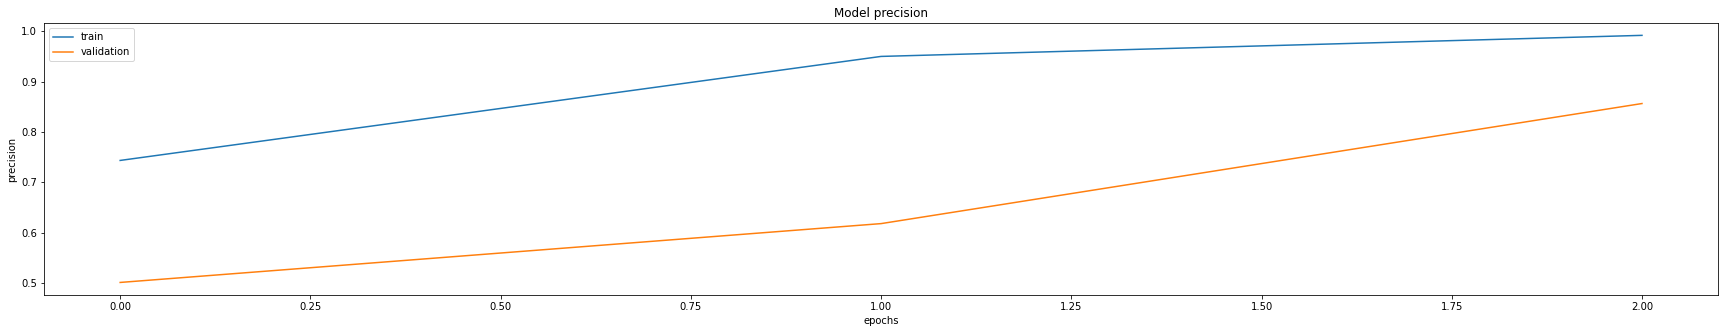

In [ ]:
plot_metric('loss', history)
plot_metric('auc', history)
plot_metric('accuracy', history)
plot_metric('precision', history)

Found 1279 files belonging to 4 classes.
20/20 [==============================] - 131s 6s/step - loss: 0.9833 - accuracy: 0.8434 - precision: 0.6915 - recall: 0.6747 - auc: 0.8981


<BarContainer object of 5 artists>

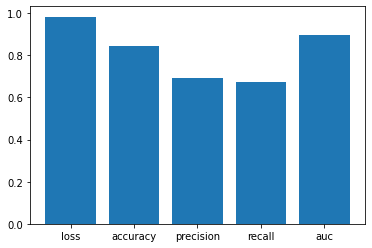

In [ ]:
test = image_dataset_from_directory(
    DIRECTORY_TEST,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test = test.map(one_hot_label)
result = model.evaluate(test)
plt.bar([0, 1, 2, 3, 4], result, tick_label = ["loss", "accuracy", "precision", "recall", "auc"])